In [1]:
%matplotlib inline
import seaborn as sns

import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import sklearn
import sys
sys.path.append(str(Path.cwd().parent / "src"))

from preprocess import *

メトリックはメトリック，DBパラメータはDBパラメータで依存関係を見る

In [2]:
ro = "read_only_0"
wo = "write_only_0"
rw = "read_write_0"

In [3]:
data_dir = Path("../data/")
read_dir = data_dir / "read_only_0"
write_dir = data_dir / "write_only_0"
read_write_dir = data_dir / "read_write_0"
dir_lst = [read_dir, write_dir, read_write_dir]
df_dict = make_dataframe_dict(dir_lst)
db_params_dict = make_db_params_dict(dir_lst)

In [71]:
df_rw = df_dict[rw]
df_ro = df_dict[ro]
df_wo = df_dict[wo]

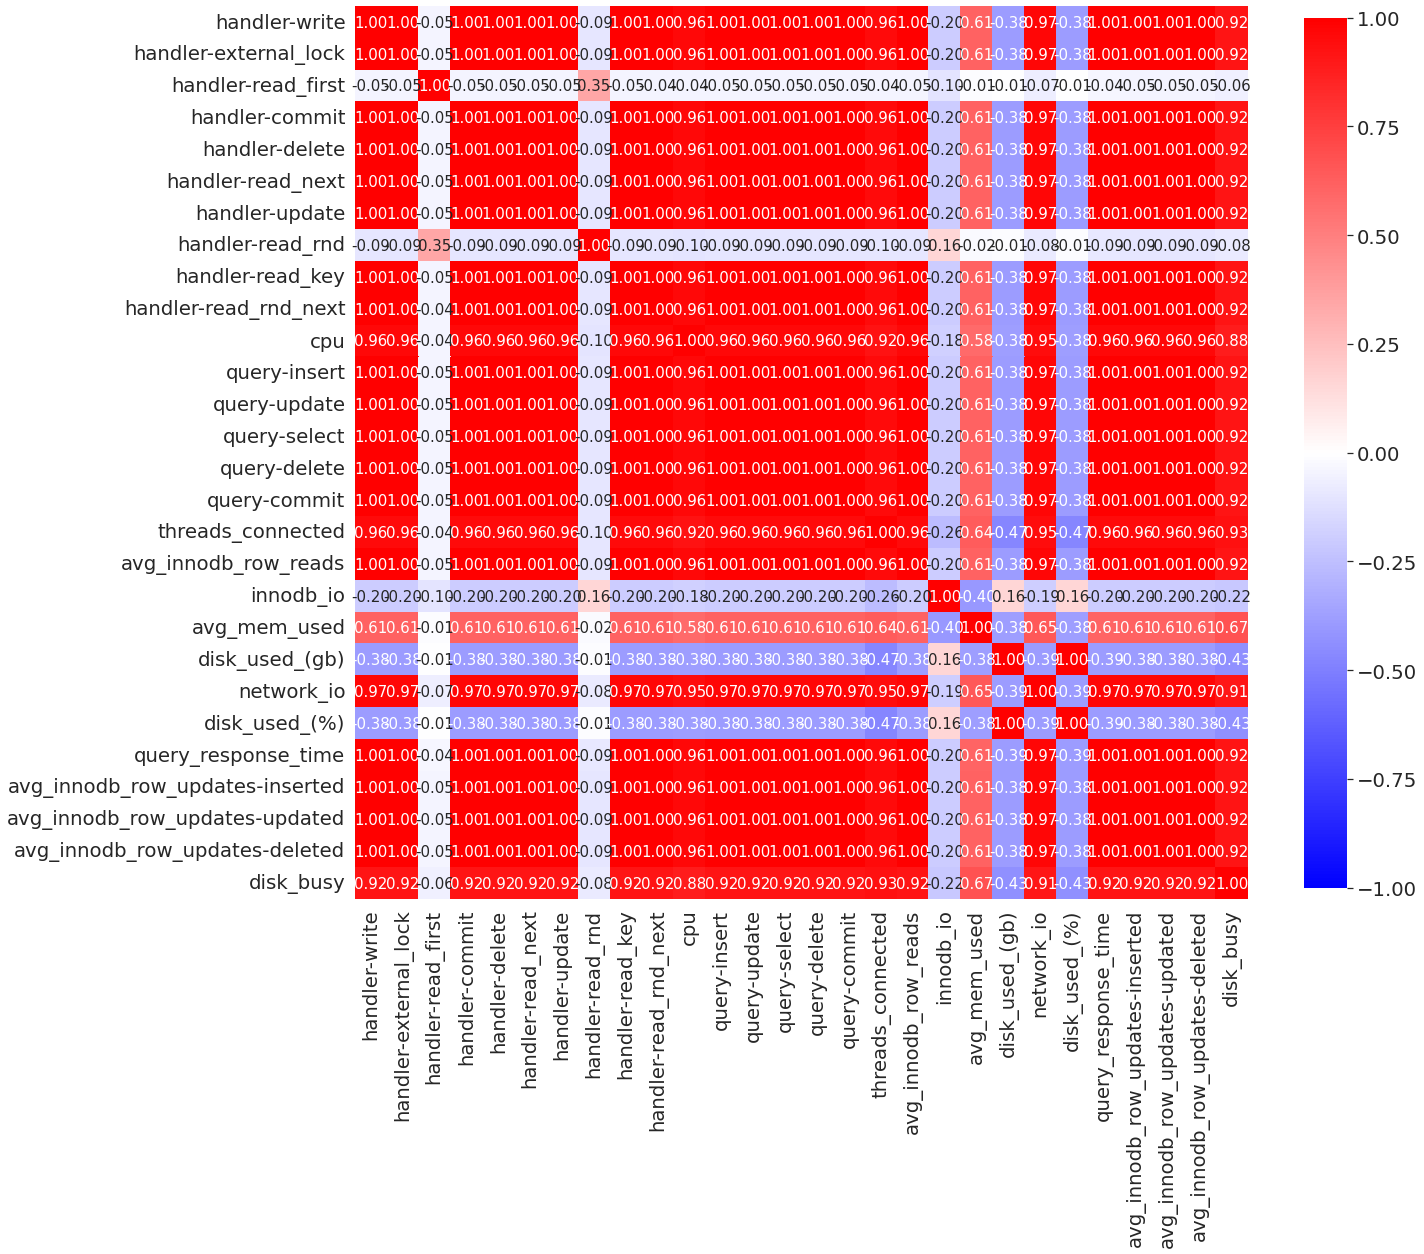

In [5]:
# read_write
# 値が全て同じの列以外で分析
df_rw = df_rw.loc[:, df_rw.nunique()!=1]
sns.set(font_scale=1.8)
plt.figure(figsize=(20, 20))
sns.heatmap(df_rw.drop("innodbu_io_capacity", axis=1).corr(), vmax=1, vmin=-1, center=0, annot=True, square=True, cmap="bwr", annot_kws={"size": 15}, cbar_kws={"shrink": 0.8}, fmt=".2f")
plt.show()

### read_only, write_only, read_writeのデータをまとめて分析
- 実データに近い相関を見たい
- それぞれのデータを独立に扱う

In [6]:
df = pd.concat(df_dict.values())
df.drop(["innodbu_io_capacity", "innodb_buffer_pool"], axis=1, inplace=True)
df = df.loc[:, df.nunique() != 1]

### 値が全て同じとなる列以外で分析

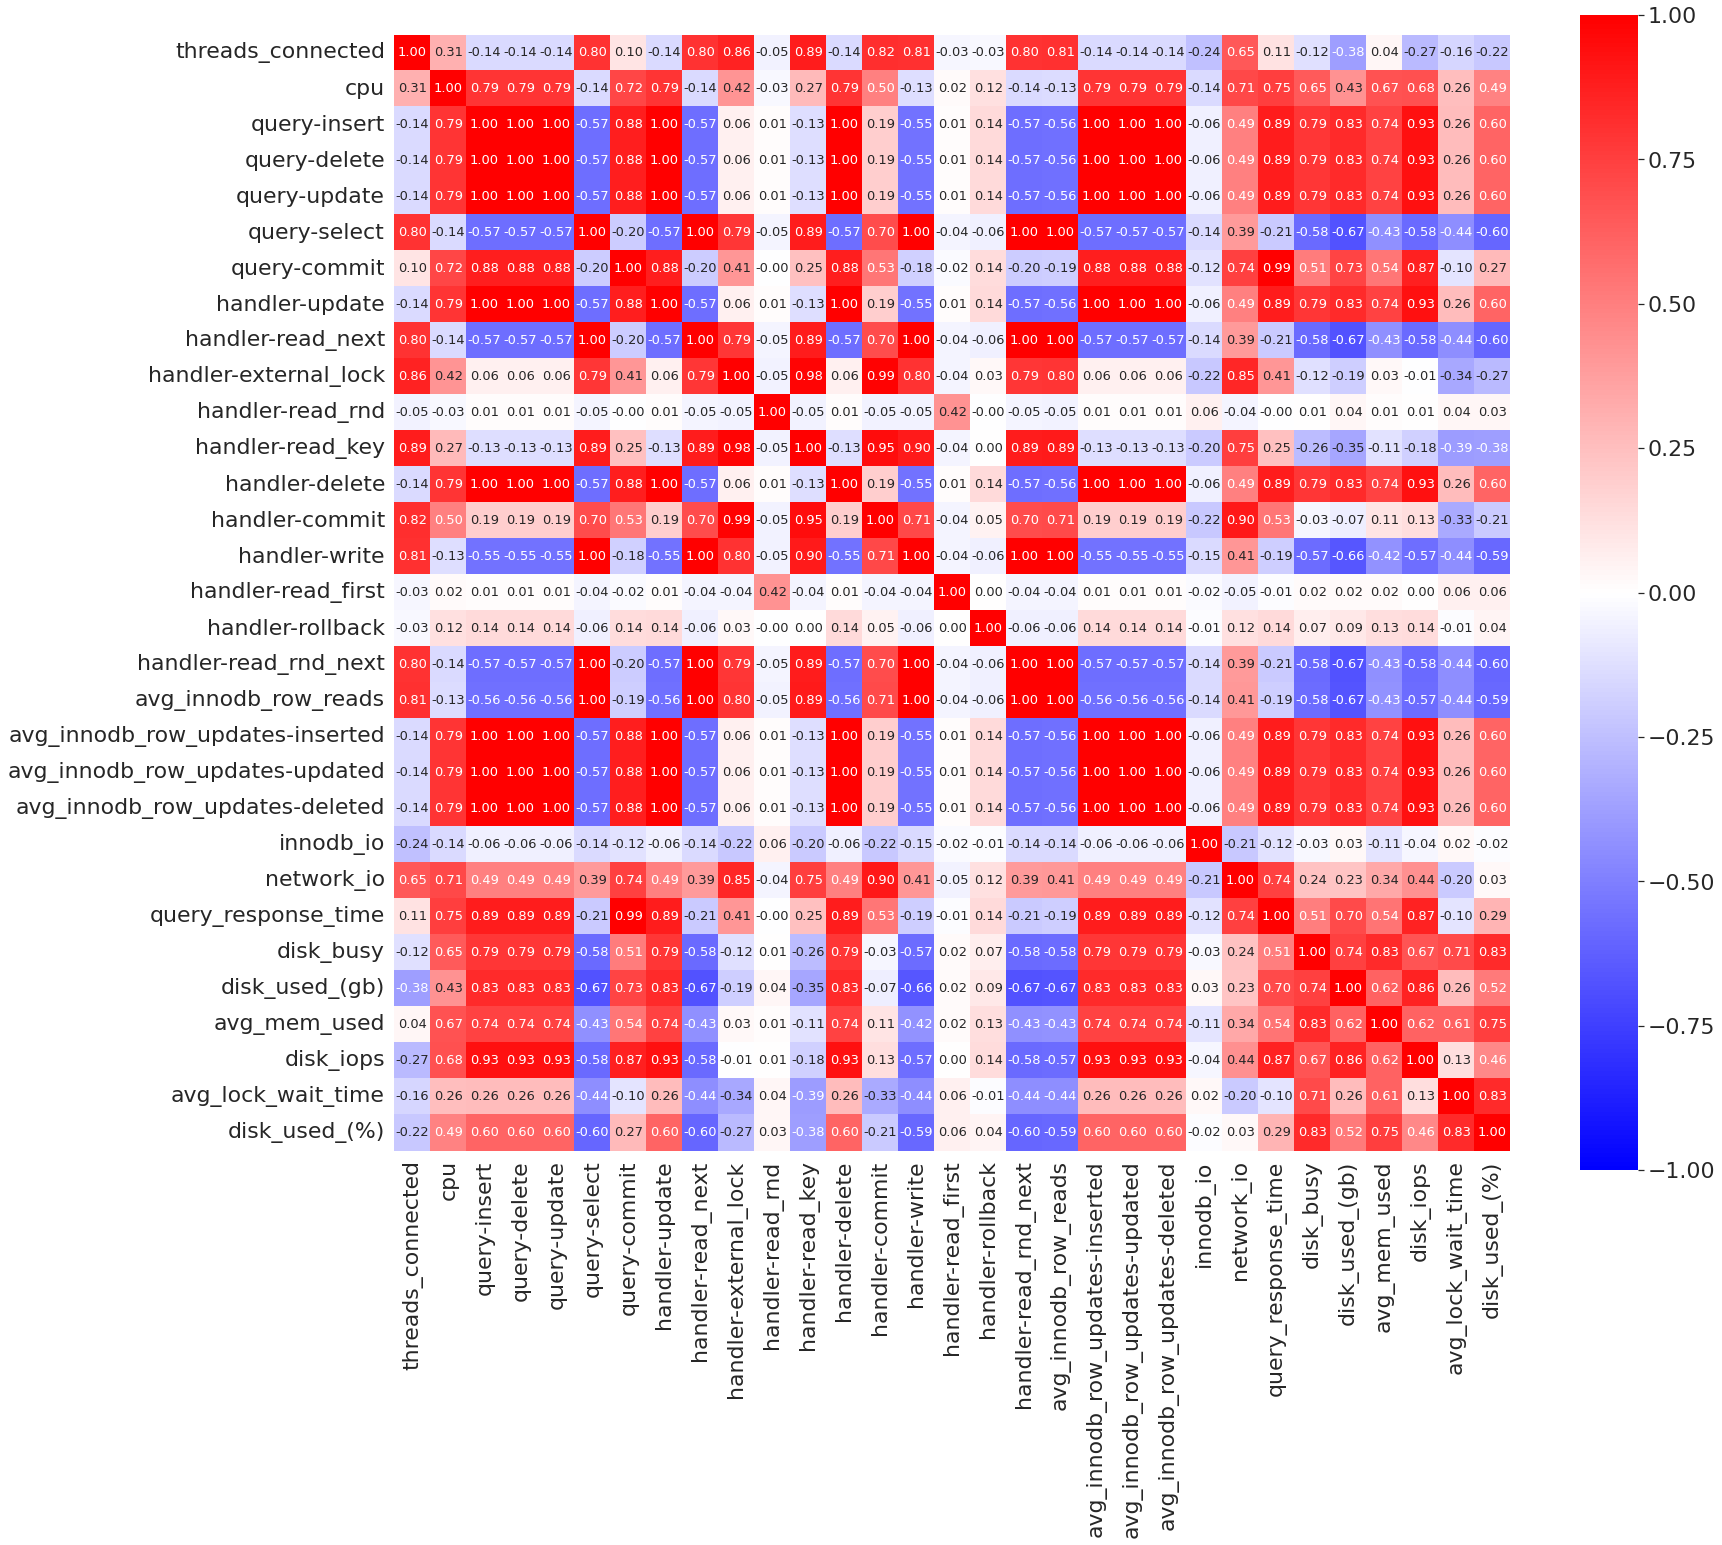

In [7]:
# 値が全て同じの列以外で分析
sns.set(font_scale=2)
plt.figure(figsize=(25, 25))
sns.heatmap(df.corr(), vmax=1, vmin=-1, center=0, annot=True, square=True, cmap="bwr", annot_kws={"size": 13}, fmt=".2f", cbar_kws={"shrink": 0.85})
plt.show()

### 列名が "avg_innodb_" のものを削除
- avg_innodb_row_updates-inserted
- avg_innodb_row_updates-updated
- avg_innodb_row_updates-deleted

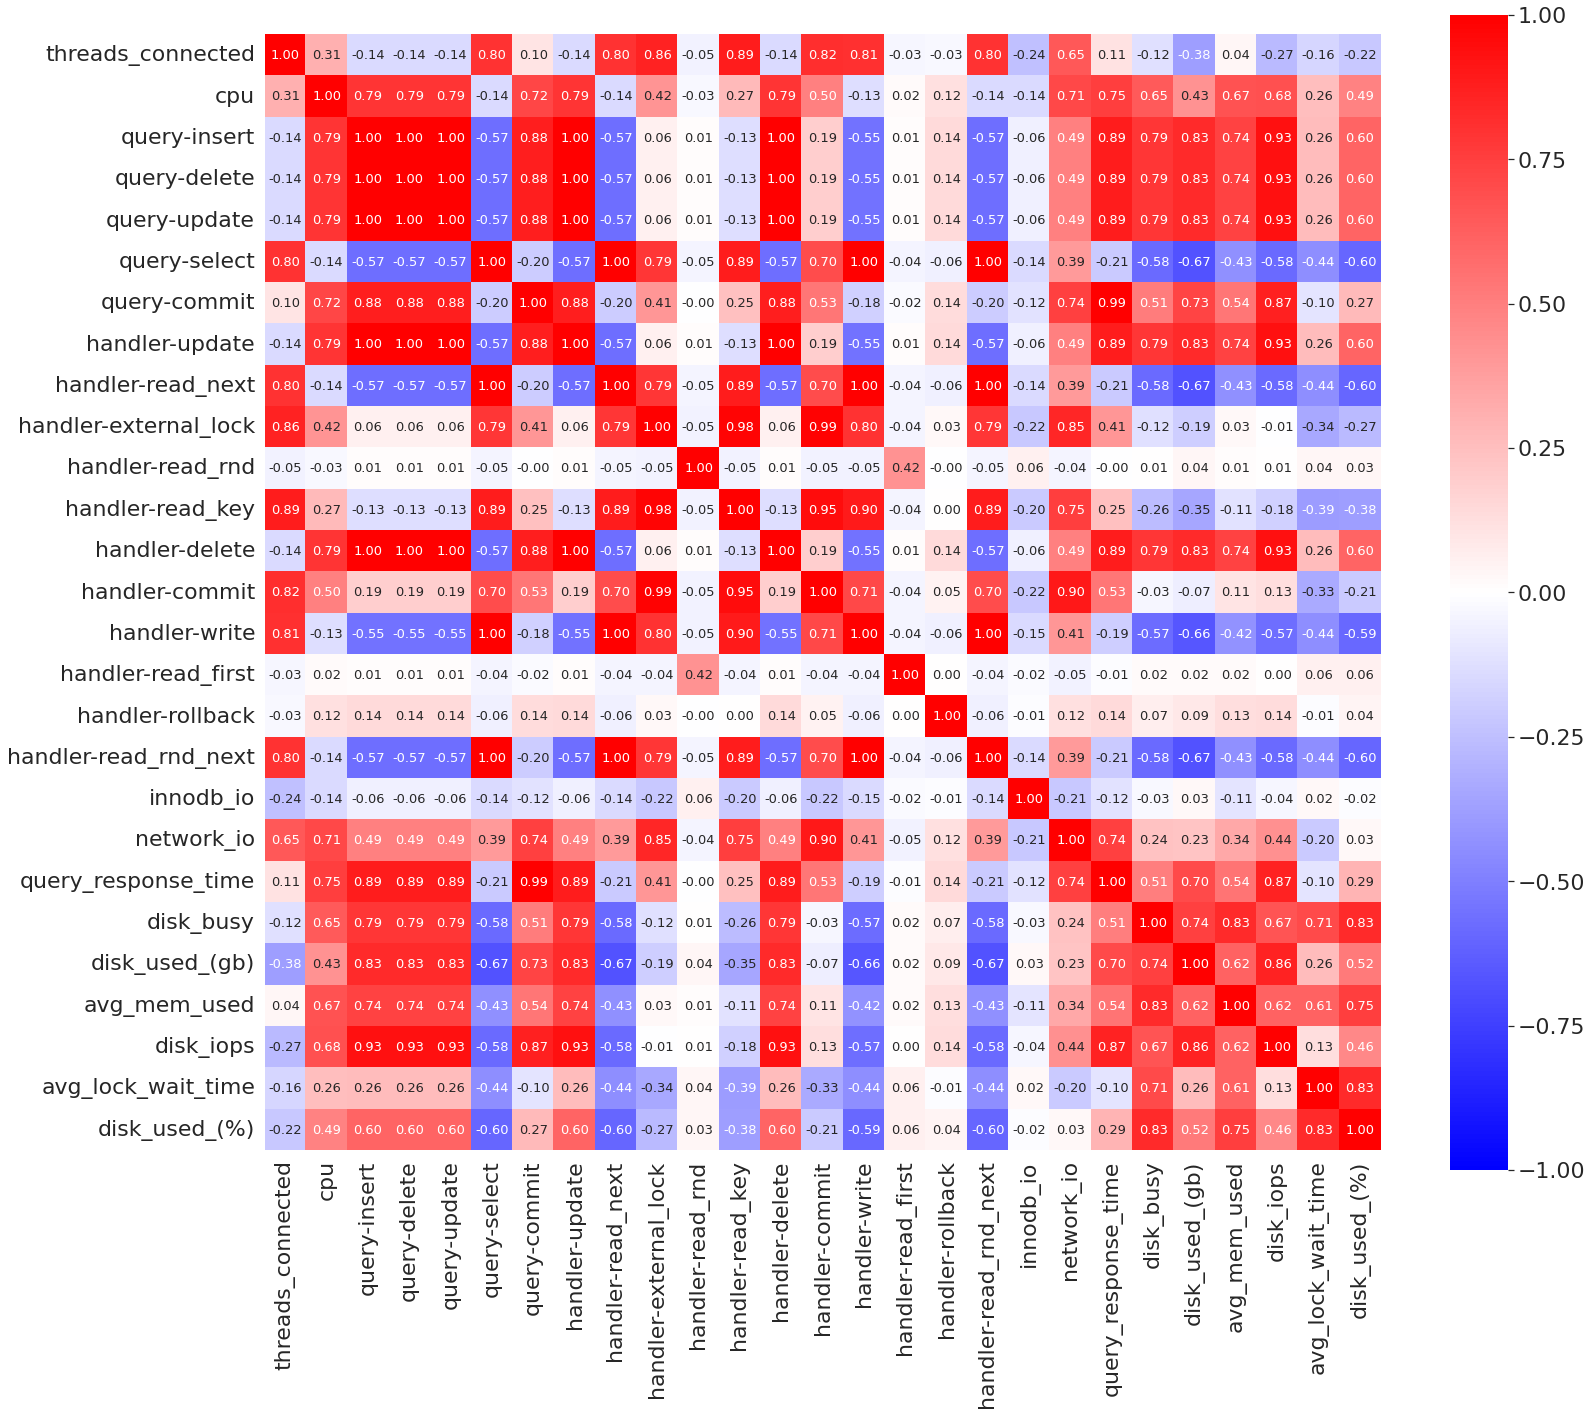

In [8]:
mask_avg_innodb = [c for c in df.columns if c[:10] != "avg_innodb"]
sns.set(font_scale=2)
plt.figure(figsize=(25, 25))
sns.heatmap(df[mask_avg_innodb].corr(), vmax=1, vmin=-1, center=0, annot=True, square=True, cmap="bwr", annot_kws={"size": 13}, fmt=".2f", cbar_kws={"shrink": 0.85})
plt.show()

## 特徴量選択
### 考えられる手法
- 目的変数が確定しているのなら，mRMR(minium-Redundancy-Maximum-Relevance)が使えそう．
- 単純に線形依存している特徴量を 片方削除 or 加算 or 積算
    - 相関が高い関係にあるメトリックス数が多いメトリックから順に消していく
    - もしくは，あるメトリックについて，各メトリックとの相関係数が0.7以上となる相関係数の値の和でランク付けして削除していく
        - 結局相関係数が高いものの個数に依存するので，そこまで変化はなさそう．

特徴量選択した後に次元削減

### 相関が高いメトリックスを列挙

In [20]:
df = df[mask_avg_innodb]
df_corr = df.corr()
cols = df_corr.columns

th = 0.85

# 相関が th 以上 or -th 以下のメトリックを取り出す
high_corr_lst = []

# 相関が高いメトリック間の関係数をメトリック別に列挙
# （メトリックごとの関係数を相関係数の和で代用してもいい）
high_corr_dict = {k: 0 for k in cols}

corr_mat = df_corr.to_numpy()
for i, j in zip(*np.where((corr_mat >= th) | (corr_mat <= -th))):
    if i < j and not (cols[i][:6] == "query-" and cols[j][:6] == "query-") and not (cols[i][:7] == "handler" and cols[j][:7] == "handler"): # query-*同士は現実にはここまで相関がないはずなので除外
        high_corr_lst.append([cols[i], cols[j], corr_mat[i, j]])
        high_corr_dict[cols[i]] += 1
        high_corr_dict[cols[j]] += 1
high_corr_lst

[['threads_connected', 'handler-external_lock', 0.8641125683564032],
 ['threads_connected', 'handler-read_key', 0.8856179451458462],
 ['query-insert', 'handler-update', 0.9999999983212865],
 ['query-insert', 'handler-delete', 0.9999999989141445],
 ['query-insert', 'query_response_time', 0.8865148665261807],
 ['query-insert', 'disk_iops', 0.9309218749384409],
 ['query-delete', 'handler-update', 0.9999999983587212],
 ['query-delete', 'handler-delete', 0.9999999994003802],
 ['query-delete', 'query_response_time', 0.8865144796572061],
 ['query-delete', 'disk_iops', 0.9309238008875875],
 ['query-update', 'handler-update', 0.9999999990007251],
 ['query-update', 'handler-delete', 0.9999999983757668],
 ['query-update', 'query_response_time', 0.8865147785067151],
 ['query-update', 'disk_iops', 0.9309227200723665],
 ['query-select', 'handler-read_next', 0.999999999561968],
 ['query-select', 'handler-read_key', 0.8884182282339245],
 ['query-select', 'handler-write', 0.9998381759009135],
 ['query-

In [35]:
from pprint import pprint

In [95]:
df = df[mask_avg_innodb]
df_corr = df.corr()
corr_mat = df_corr.to_numpy()
cols = df_corr.columns

th = 0.8
del_num = 9

# 相関が th 以上 or -th 以下のメトリックを取り出す
high_corr_dict = {}
for i, j in zip(*np.where((corr_mat >= th) | (corr_mat <= -th))):
    if i < j and not (cols[i][:6] == "query-" and cols[j][:6] == "query-") and not (cols[i][:7] == "handler" and cols[j][:7] == "handler"): # query-*同士は現実にはここまで相関がないはずなので除外
        if cols[i] in high_corr_dict:
            high_corr_dict[cols[i]].add(cols[j])
        else:
            high_corr_dict[cols[i]] = {cols[j]}
        if cols[j] in high_corr_dict:
            high_corr_dict[cols[j]].add(cols[i])
        else:
            high_corr_dict[cols[j]] = {cols[i]}

del_metrics = []
for _ in range(del_num):
    # 相関が高いメトリック間の関係数をメトリック別に列挙
    # （メトリックごとの関係数を相関係数の和で代用してもいい）
    del_metric = max(high_corr_dict.items(), key=lambda item: len(item[1]))[0]
    high_corr_dict.pop(del_metric, None) # キーを削除
    for k, v_set in high_corr_dict.items():
        if del_metric in v_set:
            v_set.discard(del_metric)
    # pprint(high_corr_dict)
    # print()
    del_metrics.append(del_metric)

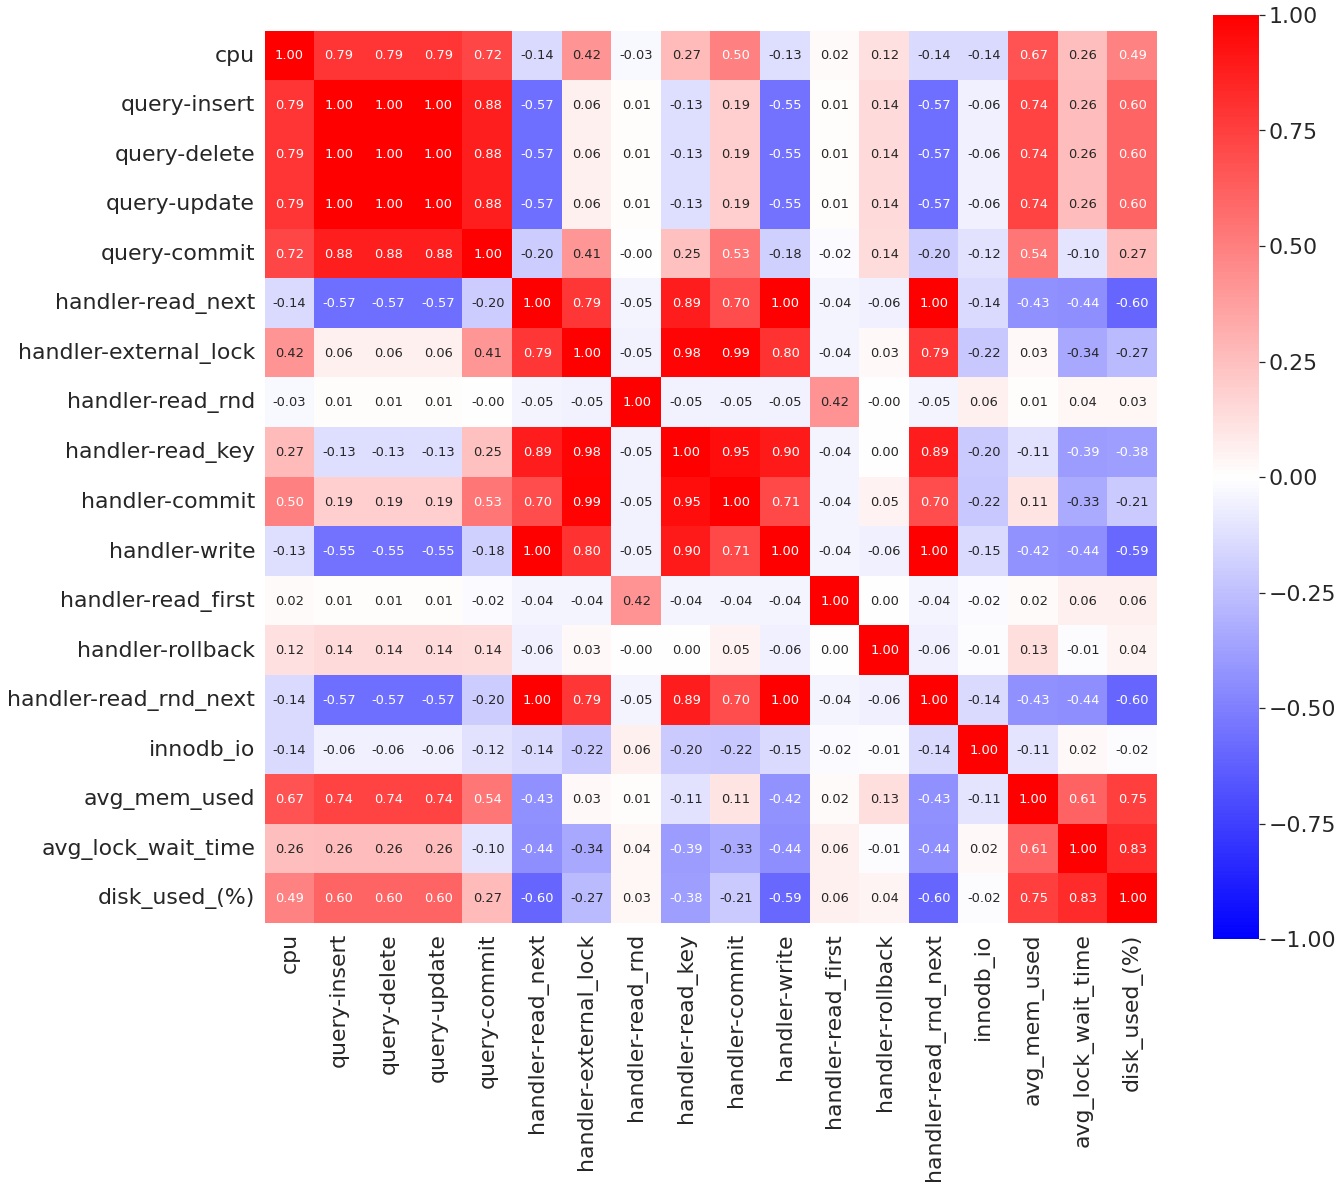

In [96]:
df = df[mask_avg_innodb]
df_selected = df.drop(del_metrics, axis=1)
sns.set(font_scale=2)
plt.figure(figsize=(20, 20))
sns.heatmap(df_selected.corr(), vmax=1, vmin=-1, center=0, annot=True, square=True, cmap="bwr", annot_kws={"size": 13}, fmt=".2f", cbar_kws={"shrink": 0.85})
plt.show()